# 预训练BERT

利用`sec_bert`中实现的BERT模型和`sec_bert-dataset`中从WikiText-2数据集生成的预训练样本，我们将在本节中在WikiText-2数据集上对BERT进行预训练。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。批量大小是512，BERT输入序列的最大长度是64。注意，在原始BERT模型中，最大长度是512。

In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki1(batch_size, max_len)  # 因原网页链接失效，使用 load_data_wiki1 替换原函数 load_data_wiki

## 预训练BERT

原始BERT`Devlin.Chang.Lee.ea.2018`有两个不同模型尺寸的版本。基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。

值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。

In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus_mps()
loss = nn.CrossEntropyLoss()

在定义训练代码实现之前，我们定义了一个辅助函数`_get_batch_loss_bert`。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。

In [4]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    
    # 前向传播。由于预训练时不需要用到 BERT 中 ENCODER 的输出，因此这里使用 _ 忽略掉（fine-tuning 时需要用到）
    # mlm_Y_hat: 预测的 MLM 词元概率分布；nsp_Y_hat: 预测的 NSP 二分类概率
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X)

    # 计算遮蔽语言模型（MLM）损失
    # 调整 mlm_Y_hat 的维度为 (batch_size * num_predictions, vocab_size)，以匹配目标 mlm_Y
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)  # mlm_weights_X 起到掩码的作用
    # 对损失求和后，按预测词元的总数进行平均
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)

    # 计算下一句子预测任务（NSP）的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)

    # 总损失
    l = mlm_l + nsp_l  # 这里也可以考虑用加权平均的方式来平衡两者的损失
    
    return mlm_l, nsp_l, l

通过调用上述两个辅助函数，下面的`train_bert`函数定义了在WikiText-2（`train_iter`）数据集上预训练BERT（`net`）的过程。训练BERT可能需要很长时间。以下函数的输入`num_steps`指定了训练的迭代步数，而不是像`train_ch13`函数那样指定训练的轮数（参见`sec_image_augmentation`）。

In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])  # 如果允许，使用多 GPU 并行计算
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)  # Adam 优化器
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False

    # 和之前网络的训练不同：这里使用 step 记录训练了多少个 batch，而不是多少轮所有数据 epoch
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            # 把数据移到 GPU 上
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])

            trainer.zero_grad()  # 梯度清零
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()  # 更新模型参数

            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。


MLM loss 5.388, NSP loss 0.738
2256.4 sentence pairs/sec on [device(type='mps', index=0)]


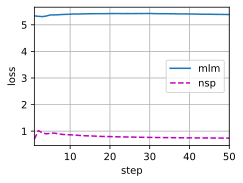

In [8]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)
# 因为训练的 batch 过少，所以模型显然没有收敛（一般来说需要训练百万次左右才可以取得较好的效果）

## 用BERT表示文本

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回`tokens_a`和`tokens_b`中所有词元的BERT（`net`）编码表示。

**返回输入文本的编码表示 encoded_X 包含了每个词元的上下文信息，可用于下游 NLP 任务（如分类、问答等）。**

In [9]:
# 用于获取输入文本的 BERT 编码表示
def get_bert_encoding(net, tokens_a, tokens_b=None):
    # okenization and Segment Processing
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    # Forward Pass through BERT
    encoded_X, _, _ = net(token_ids, segments, valid_len)  # (encoded_X, mlm_Y_hat, nsp_Y_hat)
    # 返回输入文本的编码表示 encoded_X，它包含了每个词元的上下文信息，可用于下游 NLP 任务（如分类、问答等）
    return encoded_X

考虑“a crane is flying”这句话。回想一下`subsec_bert_input_rep`中讨论的BERT的输入表示。插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，BERT输入序列的长度为6。因为零是“&lt;cls&gt;”词元，`encoded_text[:, 0, :]`是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。

In [10]:
# 需要编码的词元列表
tokens_a = ['a', 'crane', 'is', 'flying']
# encoded_text 形状为 (batch_size, sequence_length, hidden_size)
# 注：sequence_length 包含特殊词元（如 '<cls>' 和 '<sep>'）在内的总词元数量，故这里 sequence_length=6
encoded_text = get_bert_encoding(net, tokens_a)

# 词元列表（seq_len=6）：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]  # '<cls>' 的编码表示
encoded_text_crane = encoded_text[:, 2, :]  # 'crane' 词元的编码表示

# encoded_text：(batch_size, sequence_length, hidden_size)
# encoded_text_cls：(batch_size, hidden_size)
# encoded_text_crane[0][:3] 提取 encoded_text_crane 中的前三个维度的值，用于查看编码内容
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.1968,  0.1536, -0.0192], device='mps:0', grad_fn=<SliceBackward0>))

现在考虑一个句子对：“a crane driver came”和“he just left”。类似地，`encoded_pair[:, 0, :]`是来自预训练BERT的整个句子对的编码结果。

**注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了 BERT 表示是上下文敏感的。**

In [11]:
# 需要编码的句子对
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)

# 词元列表：'<cls>','a','crane','driver','came','<sep>','he','just','left','<sep>'
# 注：sequence_length 包含特殊词元（如 '<cls>' 和 '<sep>'）在内的总词元数量，故这里 sequence_length=10
encoded_pair_cls = encoded_pair[:, 0, :]  # '<cls>' 的编码表示
encoded_pair_crane = encoded_pair[:, 2, :]  # 'crane' 词元的编码表示

# encoded_text_crane[0][:3] 依旧代表 'crane' 词元的编码表示
# 但因为 BERT 是上下问敏感的，所以此时句子对中 crane 的编码表示与上一 chunk 单个句子里 crane 的编码表示不同
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-1.9981,  2.1542, -0.0328], device='mps:0', grad_fn=<SliceBackward0>))

在`chap_nlp_app`中，我们将为下游自然语言处理应用微调预训练的BERT模型。

## 小结

* 原始的BERT有两个版本，其中基本模型有1.1亿个参数，大模型有3.4亿个参数。
* 在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。
* 在实验中，同一个词元在不同的上下文中具有不同的BERT表示。这支持BERT表示是上下文敏感的。

## 练习

1. 在实验中，我们可以看到遮蔽语言模型损失明显高于下一句预测损失。为什么？
2. 将BERT输入序列的最大长度设置为512（与原始BERT模型相同）。使用原始BERT模型的配置，如$\text{BERT}_{\text{LARGE}}$。运行此部分时是否遇到错误？为什么？

[Discussions](https://discuss.d2l.ai/t/5743)
